# Intra-household allocation of time
Inspired by [Siminski and Yetsenga (2022)](https://www.journals.uchicago.edu/doi/full/10.1086/718430).
## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from DynamicSpecializationModel import DynamicSpecializationModelClass

In [2]:
# solve and simulate baseline model
model = DynamicSpecializationModelClass()
%time model.solve()
%time model.simulate()

Wall time: 3.51 s
Wall time: 1.26 s


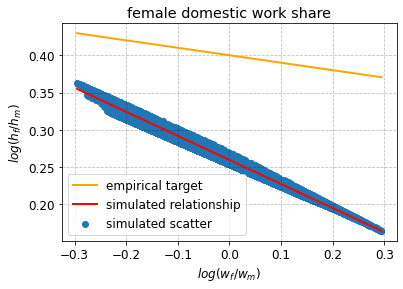

In [3]:
# plot the relationship between wages and hours in home production
model.plot()

In [4]:
def calculate_event_mean(model,outcome_str,min_time=-5,max_time=5,relative=-1,pct=True):
    ''' calculate average outcome across time since birth '''

    par = model.par
    sim = model.sim

    # time since birth
    periods = np.tile([t for t in range(par.simT)],(par.simN,1))
    time_of_birth = np.max(periods * sim.birth, axis=1)

    I = time_of_birth>0
    time_of_birth[~I] = -1000 # never has a child
    time_of_birth = np.transpose(np.tile(time_of_birth , (par.simT,1)))

    time_since_birth = periods - time_of_birth

    # event-study mean
    outcome = getattr(sim,outcome_str)
    event_grid = np.arange(min_time,max_time+1)

    event_outcome = np.nan + np.zeros(event_grid.size)
    for t,time in enumerate(event_grid):
        event_outcome[t] = np.mean(outcome[time_since_birth==time])

    # relative to period before birth
    if relative is not None:
        event_outcome_rel = event_outcome - event_outcome[event_grid==relative]
        if pct:
            event_outcome = event_outcome_rel/event_outcome[event_grid==relative]
        else:
            event_outcome = event_outcome_rel

    # return the indicators of distance to event along with the average outcome for each time periode            
    return event_grid,event_outcome

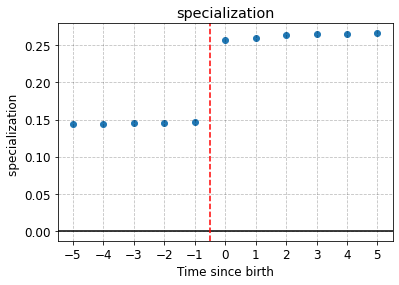

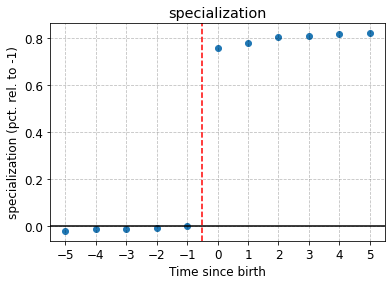

In [5]:
for relative in (None,-1):
    for val in ('specialization',):
            
        event_grid,event_rel = calculate_event_mean(model,val,min_time=-5,max_time=5,relative=relative,pct=True)
        
        rel = ''
        if relative is not None:
            rel = '(pct. rel. to -1)'
        fig, ax = plt.subplots()
        ax.scatter(event_grid,event_rel)
        ax.axhline(y=0,color='black')
        ax.axvline(x=-0.5,color='red',linestyle='dashed')
        ax.set(title=val,xlabel='Time since birth',ylabel=f'{val} {rel}',xticks=event_grid);

## Structural Estimation

In [6]:
# data moments
moms_data = np.array([0.4,-0.1,1.0])

In [7]:
# objective function
def calc_moments(model):
    # a. regression coefficients
    constant,slope = model.regress()

    # b. event study effect
    _,event_rel = calculate_event_mean(model,'specialization',min_time=-2,max_time=0,relative=-1,pct=True)
    event = event_rel[-1]

    # c. combine moments
    return np.array([constant,slope,event])

# equal weighting (although the weigting matrix does not matter since #moments=#parameters)
def obj(theta,theta_names,model,moms_data,do_print=False):
    
    # a. update parameters
    for i,name in enumerate(theta_names):
        setattr(model.par,name,theta[i])

    # b. solve and simulate model
    model.solve()
    model.simulate()

    # c. calcualte moment differences
    moms_sim = calc_moments(model)
    diff = moms_sim - moms_data
    sqsum = np.sum(diff*diff)

    # d. print
    if do_print: 
        [print(f'{name}:{theta[i]:2.3f} ',end='') for i,name in enumerate(theta_names)]
        print(f'-> sqsum={sqsum:2.8f}',end="\r")
    
    # e. return squared difference
    return sqsum

In [8]:
# set parameters and initial values
theta_names = ('alpha','sigma','omega_n')
theta_init = np.array([0.98,0.1,-0.25])

obj_init = obj(theta_init,theta_names,model,moms_data,do_print=True)

In [9]:
# estimate using a numerical solver
obj_func = lambda theta: obj(theta,theta_names,model,moms_data,do_print=True)

est = minimize(obj_func,theta_init,method='nelder-mead')

The estimate of $\alpha$ implies that women are around $\alpha/(1-\alpha)\approx50$ times as productive in home production as men in order to fit the data.

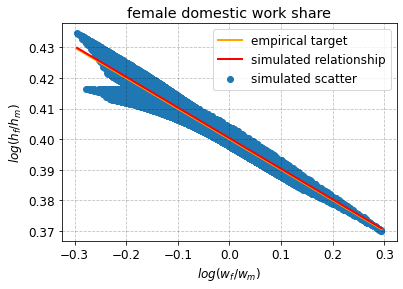

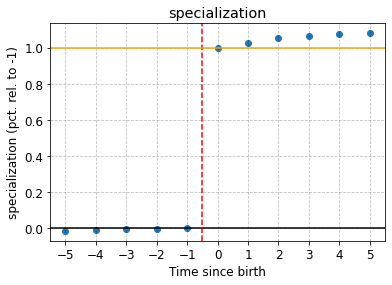

In [10]:
# since the model-object already has the estimated parameters updated, we can now plot the model fit
model.plot()

for val in ('specialization',):
        
    event_grid,event_rel = calculate_event_mean(model,val,min_time=-5,max_time=5,relative=-1,pct=True)

    fig, ax = plt.subplots()
    ax.scatter(event_grid,event_rel)
    ax.axhline(y=0,color='black')
    ax.axvline(x=-0.5,color='red',linestyle='dashed')
    ax.axhline(y=1.0,color='orange')
    ax.set(title=val,xlabel='Time since birth',ylabel=f'{val} (pct. rel. to -1)',xticks=event_grid);

## Labor supply of men around childbirth

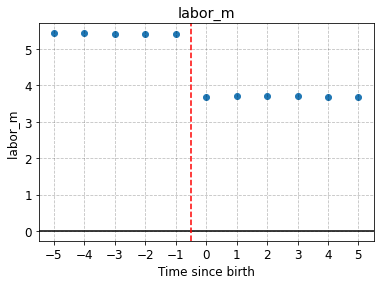

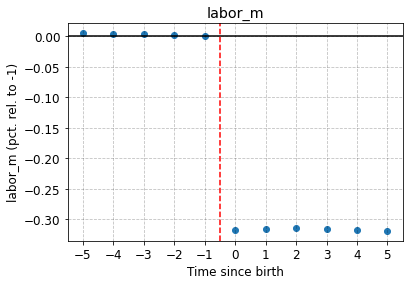

In [11]:
for relative in (None,-1):
    for val in ('labor_m',):
            
        event_grid,event_rel = calculate_event_mean(model,val,min_time=-5,max_time=5,relative=relative,pct=True)
        
        rel = ''
        if relative is not None:
            rel = '(pct. rel. to -1)'
        fig, ax = plt.subplots()
        ax.scatter(event_grid,event_rel)
        ax.axhline(y=0,color='black')
        ax.axvline(x=-0.5,color='red',linestyle='dashed')
        ax.set(title=val,xlabel='Time since birth',ylabel=f'{val} {rel}',xticks=event_grid);